In [1]:
import pandas as pd
from utils import sparksession, Q, QClust
from context import GeneticRangeAnalysis, MSSelector, RangeAnalysis, GA, BranchAndBound, FitnessUtils, DeCaf
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from operator import itemgetter
import time
from math import log2
import random
import numpy as np
from deap.tools import sortNondominated
import json
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import multiprocessing
from sklearn.cluster import estimate_bandwidth

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)

In [3]:
frontend = 'HomeControllerHome'
get_rpcs = lambda traces: [c for c in traces.columns if c != 'traceId' and c != 'experiment' and c != frontend]

In [4]:
spark = sparksession()

In [5]:
def kclustering(traces, sla, Clustering):
    rpcs = get_rpcs(traces)
    anomalytraces = traces[traces[frontend]>sla]
    dflist = []
    for k in range(2, 11):
        df = anomalytraces.select(['experiment', 'traceId'] + rpcs).toPandas()
        clust = Clustering(k)
        df['pred'] = clust.fit_predict(df[rpcs])
        dflist.append(df)
    return dflist

In [6]:
def hierarchical(traces, sla):
    return kclustering(traces, sla, AgglomerativeClustering)

In [7]:
def kmeans(traces, sla):
    return kclustering(traces, sla, KMeans)

In [8]:
def meanshift(traces, sla):
    anomalytraces = traces[traces[frontend]>sla]
    rpcs = get_rpcs(traces)
    df = anomalytraces.select(['experiment', 'traceId'] + rpcs).toPandas()
    clust = MeanShift(5)
    df['pred'] = clust.fit_predict(df[rpcs])
    return df

In [9]:
def split_based(traces, sla, explain):
    anomalytraces = traces[traces[frontend]>sla]
    min_bin_freq = anomalytraces.count()*0.05
    bandwidth =  estimate_bandwidth(traces.toPandas()[[frontend]], quantile=0.1)

    mss = MSSelector(anomalytraces, bandwidth=bandwidth, min_bin_freq=min_bin_freq)
    split_points = mss.select(frontend)

    ra = RangeAnalysis(explain, split_points)
    _, _, solutions = ra.explain()
    
    return list(map(itemgetter(0), solutions))

In [10]:
def thresholdsdict(traces):
    anomalytraces = traces[traces[frontend]>sla]
    min_bin_freq = anomalytraces.count()*0.05
    rpcs = get_rpcs(traces)
    mss = MSSelector(traces, min_bin_freq=min_bin_freq)
    return mss.select_foreach(rpcs)

In [11]:
def ga(traces, sla):
    td = thresholdsdict(traces)
    rpcs = get_rpcs(traces)
    explain = GA(traces, rpcs, frontend, td).compute
    return split_based(traces, sla, explain)

In [12]:
def bnb(traces, sla):
    td = thresholdsdict(traces)
    explain = BranchAndBound(traces, frontend, td).compute
    return split_based(traces, sla, explain)

In [13]:
def decaf(traces, sla):
    rpcs = get_rpcs(traces)
    dc = DeCaf(traces, frontend, rpcs,sla)
    return dc.explain(10)

In [14]:
def gra(traces, sla):
    td = thresholdsdict(traces)
    max_ = traces.select(frontend).rdd.max()[0]
    gra = GeneticRangeAnalysis(traces, frontend, td, sla, max_)
    pareto, _ = gra.explain(ngen=300, mu=30, lambda_=30)
    best = gra.best(pareto)
    print("Pareto size", len(pareto))
    print('Best sol fitnesses', best.fitness.values)
    print('Best sol number of patterns', len(best))
    return best

In [15]:
def qopt(traces, rpcs, num_pat, res):
    q = Q(traces, rpcs, num_pat, res)
    return q.metrics()

In [16]:
def qclust(traces, rpcs, num_pat, df):
    q = QClust(df, num_pat)
    return q.metrics()

In [17]:
def qkclust(traces, rpcs, num_pat, dflist):
    qs =[ qclust(traces, rpcs, num_pat, df) for df in dflist]
    return max(qs, key=itemgetter(0))

In [18]:
def experiment(algo, q, traces, num_pat):
    rpcs = get_rpcs(traces)
    sla = traces[traces['experiment']<num_pat].toPandas().min()[frontend]
    
    t1 = time.perf_counter()
    
    res = algo(traces, sla)
    
    t2 = time.perf_counter()
    
    fm, prec, rec = q(traces, rpcs, num_pat, res)
    t = t2 - t1
    return fm, prec, rec, t

In [19]:
num_rep = 20
algorithms =[("gra", gra, qopt, num_rep),
             ("ga", ga, qopt, num_rep),
             ("bnb", bnb, qopt, 1),
             ("decaf", decaf, qopt, num_rep),
             ("kmeans", kmeans, qkclust, num_rep),
             ("hierarchical", hierarchical, qkclust, num_rep)
            ]

2432
Algorithm  gra
Experiment nr. 0
Pareto size 132
Best sol fitnesses (0.9980430528375733, 0.7846153846153846, 311125.87571973243)
Best sol number of patterns 3
Quality:  0.8606465997770345 0.9974160206718347 0.7568627450980392
Execution time 14.836618963629007 



Algorithm  ga
Experiment nr. 0
9.484615384615385
Quality:  0.9901185770750986 0.99800796812749 0.9823529411764705
Execution time 35.20934862270951 



2407
Algorithm  gra
Experiment nr. 1
Pareto size 214
Best sol fitnesses (0.9978070175438597, 0.6267217630853994, 850864.2207936513)
Best sol number of patterns 5
Quality:  0.8542372881355932 1.0 0.7455621301775148
Execution time 19.651092564687133 



Algorithm  ga
Experiment nr. 1
9.349862258953168
Quality:  0.9437500000000001 1.0 0.893491124260355
Execution time 18.831410644575953 



2437
Algorithm  gra
Experiment nr. 2
Pareto size 215
Best sol fitnesses (1.0, 0.6761006289308176, 615553.9695261437)
Best sol number of patterns 3
Quality:  0.7635206786850477 0.8372093023255

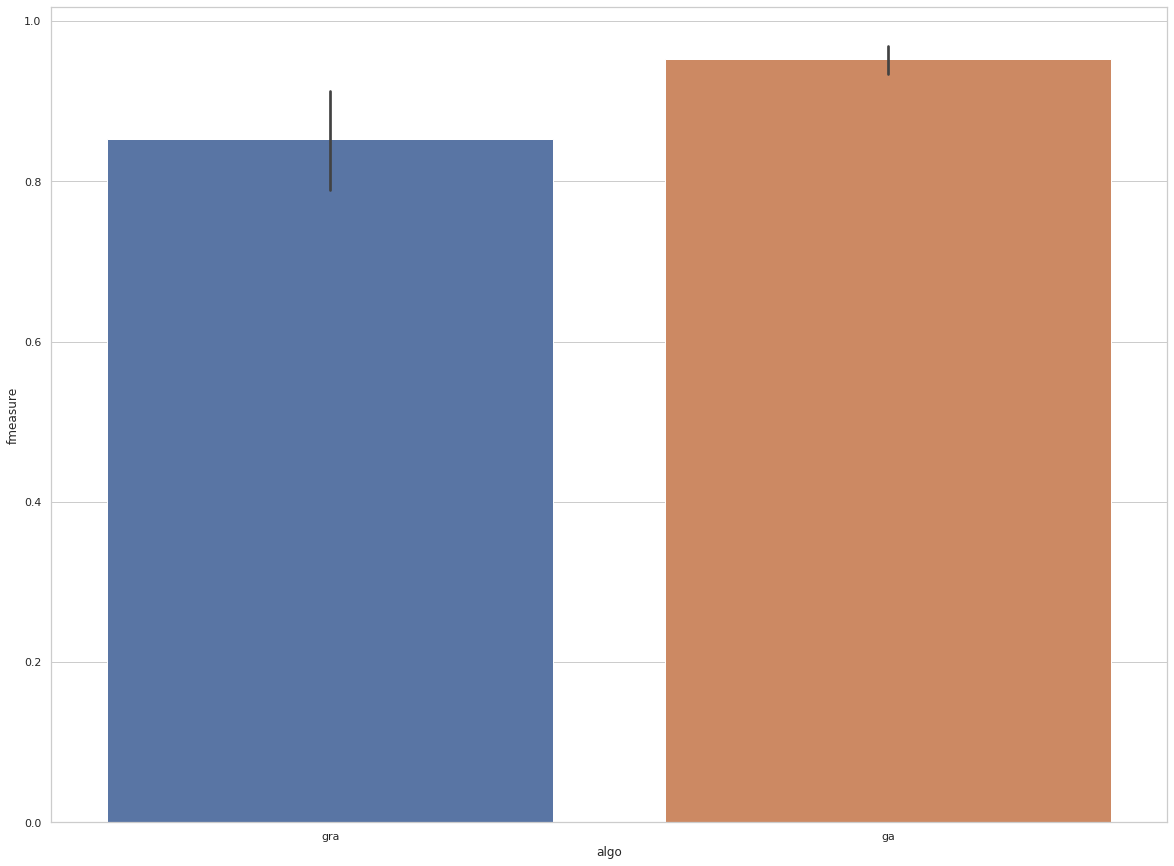

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 15)


for i in ['00', '05', '10', '15', '20']:
    datapath = '../data_/cococcia_distance_{}/'.format(i)
    respath = '../results_last/cococcia_distance{}.csv'.format(i)
    res = []
    exps = pd.read_csv( datapath+'/experiments.csv', ';', header=None)
    for row in list(exps.iterrows()):
        num_pat, from_, to =[int(x) for x in row[1]]
        traces = (spark.read.option('mergeSchema', 'true')
                  .parquet(datapath+'/%d_%d.parquet' % (from_, to)))

        print(traces.count())
        sla = traces[traces['experiment'] < num_pat].toPandas().min()[frontend]
        for name, algo, q, num_rep in algorithms:
            random.seed(33)
            np.random.seed(33)
            for j in range(num_rep):
                print('Algorithm ', name)
                print('Experiment nr.', row[0])
                fm, prec, rec, t = experiment(algo, q, traces, num_pat)
                print('Quality: ', fm, prec, rec)
                print('Execution time', t, '\n\n\n')            
                res.append([row[0], j, num_pat, name, fm, prec, rec, t])
    df = pd.DataFrame(res, columns=['exp','trial','num_pat', 'algo','fmeasure', 'precision', 'recall', 'time' ])
    df.to_csv(respath, index = None, header=True)
    sns.barplot(x='algo', y='fmeasure', data=df)
    plt.show()

In [35]:
spark.stop()

In [22]:
df.groupby('algo').mean()

,exp,trial,num_pat,fmeasure,precision,recall,time
algo,,,,,,,
ga,9.5,0.0,2.0,0.952301,0.999803,0.912093,26.355175
gra,9.5,0.0,2.0,0.852513,0.937079,0.790982,17.834759
